## Calculate the total mass of chemical species in various atmospheric layers

From the ideal gas law, $PV = m R_s T$, the molecular mass of a gas or a mixture of gases is $m = \frac{PV}{R_s T}$.

The molecular mass of the gas i is:

$m_i = \frac{PV}{R_s T}w_i$,

where $w_i$ is the mass fraction of the gas i.

The mass fraction of the gas i ($w_i$) in units of kg of gas i over kg of air is:

$w_i = f_i \frac{\mu_{i}}{\mu_{air}}$ [kg kg-1]
    
where $f_i$ is the mole fraction of the gas i, $\mu_{i}$ is the molar mass of the gas i and $\mu_{air}$ is the molar mass of air.

The molar mass of air ($\mu_{air}$) is:

$\mu_{air}=R_u/R_s$ [kg mol-1]

where $R_u$ is the universal gas constant and $R_s$ is the specific gas constant.

Therefore, the molecular mass of the gas i is:

$m_i = \frac{PV}{R_s T} f_i \frac{\mu_{i}}{R_u/R_s} = \frac{PV}{T} f_i \frac{\mu_{i}}{R_u} = \frac{PVf_i\mu_{i}}{TR_u}$.

In [1]:
import warnings
from pathlib import Path

import iris
import iris.pandas
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm as tqdm

In [2]:
from aeolus.const import init_const
from aeolus.coord import (
    get_cube_rel_days,
    interp_cube_from_height_to_pressure_levels,
    volume_weights_cube,
)
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator

In [3]:
from util_commons import GASES, PLANETS, SUITES
from util_mypaths import path_to_constants, path_to_data_umserve, path_to_results
from util_plot_func import use_paper_style

In [4]:
warnings.filterwarnings("ignore", module="iris")
use_paper_style()

In [5]:
# Constants
consts = init_const()
universal_gas_const = consts.molar_gas_constant

hatp11b_const = init_const("hatp11b", directory=path_to_constants)
hd189733b_const = init_const("hd189733b", directory=path_to_constants)
hd209458b_const = init_const("hd209458b", directory=path_to_constants)
wasp17b_const = init_const("wasp17b", directory=path_to_constants)
PLANET_CONSTS = [hatp11b_const, hd189733b_const, hd209458b_const, wasp17b_const]

In [6]:
# Parameters
metallicity = "1x solar"
gases = ["CH4", "CO", "CO2", "H2O", "HCN", "NH3"]
burden_unit = "Eg"
log_pres_thresholds = [3, 4, 5, 6, None]

In [7]:
# Process data
vrbls = {}
for planet, planet_const in zip(PLANETS.keys(), PLANET_CONSTS):
    vrbls[planet] = {}
    for exp in ["equilibrium", "kinetics"]:
        vrbls[planet][exp] = {}
        for gas in tqdm(gases):
            vrbls[planet][exp][gas] = {}
            for log_pres_threshold in log_pres_thresholds:
                if log_pres_threshold is not None:
                    thresh = 10 ** log_pres_threshold
                else:
                    thresh = 1e99  # practically nothing is masked
                # Load data
                fpath = SUITES[planet][exp][metallicity]["dir_for_merged"]
                fname = f"{SUITES[planet][exp][metallicity]['rose_suite']}.nc"
                air_temperature = iris.load_cube(str(fpath / fname), um.temp)
                air_pressure = iris.load_cube(str(fpath / fname), um.pres)
                mole_frac = iris.load_cube(str(fpath / fname), f"{gas} mole fraction")
                # Calculate grid cell volumes
                volume = volume_weights_cube(
                    air_temperature, r_planet=planet_const.planet_radius.data, model=um
                )
                # Calculate mass of the gas in each grid cell
                mass = (
                    air_pressure
                    * volume
                    * mole_frac
                    * GASES[gas]["molar_mass"]
                    / (air_temperature * universal_gas_const)
                )
                # Mask mass data where air pressure is higher than a selected threshold
                mass = mass.copy(data=np.ma.masked_where(air_pressure.data > thresh, mass.data))
                # Calculate the total mass of the gas (aka burden)
                burden = mass.collapsed(
                    ["level_height", "latitude", "longitude"], iris.analysis.SUM
                )
                burden.convert_units(burden_unit)
                # Number of simulation days since the first model output on day 10
                time_in_rel_days = get_cube_rel_days(mole_frac, model=um) + 10
                # Assemble data
                vrbls[planet][exp][gas][str(log_pres_threshold)] = {
                    "time_in_rel_days": time_in_rel_days,
                    "burden": burden,
                }

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
# Print final values of the % change of the total initial burden; select more than 1% changes
for planet in PLANETS.keys():
    for exp in ["equilibrium", "kinetics"]:
        for gas in gases:
            for log_pres_threshold in [str(i) for i in log_pres_thresholds]:
                y = (
                    iris.pandas.as_series(
                        vrbls[planet][exp][gas][log_pres_threshold]["burden"], copy=True
                    )
                    .pct_change()
                    .fillna(0)
                    .add(1)
                    .cumprod()
                    .sub(1)[-1]
                )
                if y < -1 or y > 1:
                    print(planet, exp, gas, log_pres_threshold, y)

hatp11b equilibrium HCN 3 1.2332044
hatp11b equilibrium HCN 4 1.304703
hatp11b kinetics HCN 3 1.4053061
hatp11b kinetics HCN 4 1.3304217
hatp11b kinetics HCN 5 1.277415
hatp11b kinetics NH3 3 2.3057773
hatp11b kinetics NH3 4 2.3598883
hatp11b kinetics NH3 5 2.290112
hd189733b kinetics CH4 3 1.267746
hd189733b kinetics CH4 4 1.3160114
hd189733b kinetics CH4 5 1.613785
hd189733b kinetics HCN 3 3.5385842
hd189733b kinetics HCN 4 3.5692568
hd189733b kinetics HCN 5 4.803103
hd189733b kinetics HCN 6 1.2750001
hd189733b kinetics NH3 3 3.514422
hd189733b kinetics NH3 4 3.5559397
hd189733b kinetics NH3 5 4.460771
hd209458b kinetics CH4 3 8.515365
hd209458b kinetics CH4 4 4.587428
wasp17b kinetics CH4 3 2.2565026


In [9]:
# Choose layers to plot
plt_log_pres_thresholds = [4, 5]

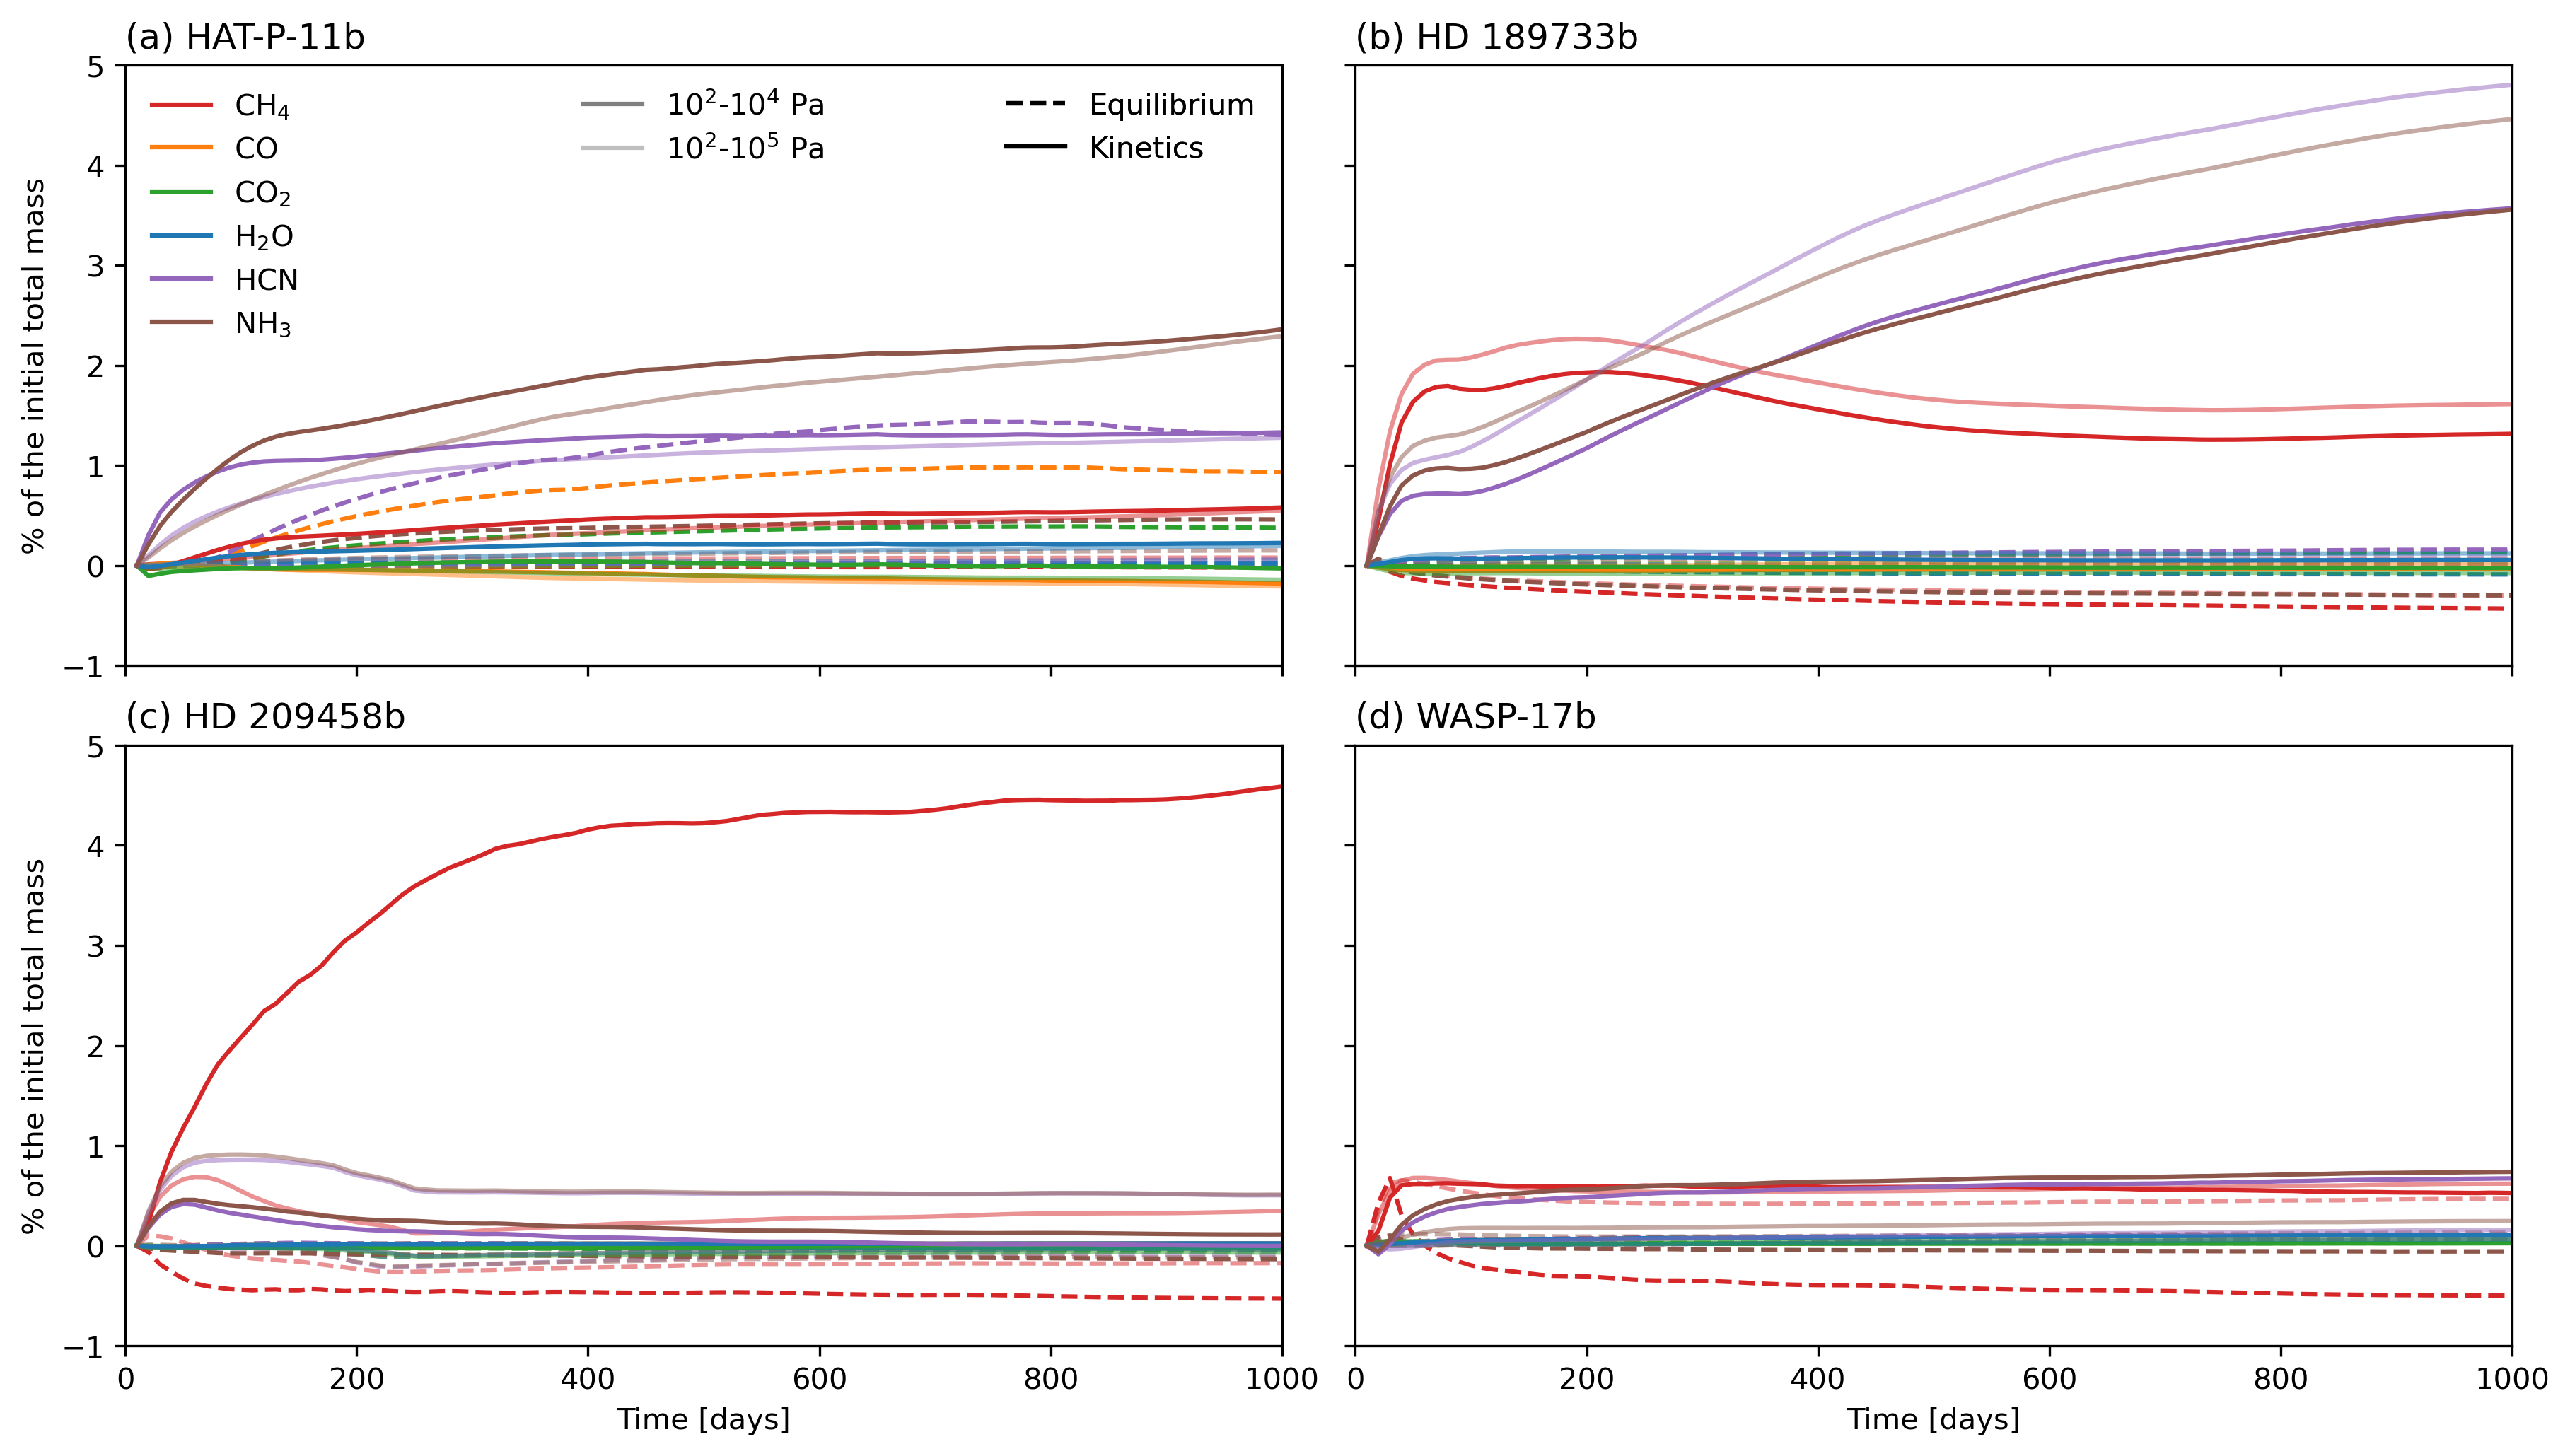

In [10]:
# Plot
fig, ax = plt.subplots(
    ncols=2, nrows=2, figsize=(12, 6.75), sharex=True, sharey=True, constrained_layout=True
)
iletters = subplot_label_generator()
for planet, iax in zip(PLANETS.keys(), ax.flatten()):
    iax.set_title(f'({next(iletters)}) {PLANETS[planet]["tex"]}', loc="left")
    for exp, linestyle in zip(["equilibrium", "kinetics"], ["dashed", "solid"]):
        for gas in gases:
            clr = GASES[gas.upper()]["color"]
            for log_pres_threshold, alpha in zip(
                [str(i) for i in plt_log_pres_thresholds], [1, 0.5]
            ):
                iax.plot(
                    vrbls[planet][exp][gas][log_pres_threshold]["time_in_rel_days"],
                    iris.pandas.as_series(
                        vrbls[planet][exp][gas][log_pres_threshold]["burden"], copy=True
                    )
                    .pct_change()
                    .fillna(0)
                    .add(1)
                    .cumprod()
                    .sub(1),
                    linestyle=linestyle,
                    color=clr,
                    alpha=alpha,
                )
    if iax.get_subplotspec().is_first_col():
        iax.set_ylabel(f"% of the initial total mass")
        if iax.get_subplotspec().is_first_row():
            add_custom_legend(
                iax,
                {
                    "$CH_4$": {"color": "C3"},
                    "$CO$": {"color": "C1"},
                    "$CO_2$": {"color": "C2"},
                    "$H_2O$": {"color": "C0"},
                    "$HCN$": {"color": "C4"},
                    "$NH_3$": {"color": "C5"},
                },
                frameon=False,
                loc="upper left",
            )
            add_custom_legend(
                iax,
                {
                    "$10^{2}$-$10^{4}$ Pa": {"color": "grey", "alpha": 1},
                    "$10^{2}$-$10^{5}$ Pa": {"color": "grey", "alpha": 0.5},
                    #                     "$10^{2}$-$10^{3}$ Pa": {"color": "grey", "alpha": 1},
                    #                     "$10^{2}$-$10^{4}$ Pa": {"color": "grey", "alpha": 0.65},
                    #                     "$10^{2}$-$10^{5}$ Pa": {"color": "grey", "alpha": 0.40},
                    #                     "$10^{2}$-$10^{6}$ Pa": {"color": "grey", "alpha": 0.20},
                    #                     "$10^{2}$-$10^{7}$ Pa": {"color": "grey", "alpha": 0.10},
                },
                frameon=False,
                loc="upper center",
            )
            add_custom_legend(
                iax,
                {
                    "equilibrium".capitalize(): {"linestyle": "dashed", "color": "k"},
                    "kinetics".capitalize(): {"linestyle": "solid", "color": "k"},
                },
                frameon=False,
                loc="upper right",
            )
for iax in ax.flatten():
    iax.set_xlim(0, 1000)
    iax.set_ylim(-1, 5)
    if iax.get_subplotspec().is_last_row():
        iax.set_xlabel("Time [days]")
# figname = f"steady_state_ts_burden_pct_of_initial_all.png"
figname = f"steady_state_ts_burden_pct_of_initial_p1e4_p1e5.png"
fig.savefig(path_to_results / "steady_state" / figname)